# Read Data

Download the 2022 Combined flight data .parquet file from here (https://www.kaggle.com/datasets/robikscube/flight-delay-dataset-20182022) into the ../data folder before running any code.

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 

columns = ["Cancelled", "DepDelayMinutes", "Distance", "Airline", "Dest", "DestStateName", "Origin", "OriginStateName", "DayOfWeek", "CRSDepTime", "DepTimeBlk", "Month"]

df = pd.read_parquet('../data/Combined_Flights_2022.parquet', columns=columns)

print(df.shape)

(4078318, 12)


# Construct New Columns

In [2]:
# Turn departure delay column into categorical features
df['OnTime'] = df['DepDelayMinutes'] == 0
df['SlightDelay'] = (df['DepDelayMinutes'] <= 15) & (df['DepDelayMinutes'] > 0)
df['MediumDelay'] = (df['DepDelayMinutes'] <= 45) & (df['DepDelayMinutes'] > 15)
df['LargeDelay'] = df['DepDelayMinutes'] > 45

# Make sure these categories are "one-hot" encoded
df.loc[df['Cancelled'], 'OnTime'] = False
df.loc[df['Cancelled'], 'SlightDelay'] = False
df.loc[df['Cancelled'], 'MediumDelay'] = False
df.loc[df['Cancelled'], 'LargeDelay'] = False

# Merge the columns into a single label
df['FlightStatus'] = df[['Cancelled','OnTime','SlightDelay','MediumDelay','LargeDelay']].idxmax(1).astype('category')

print(df.shape)

(4078318, 17)


# Exploratory Data Analysis

<Figure size 500x300 with 0 Axes>

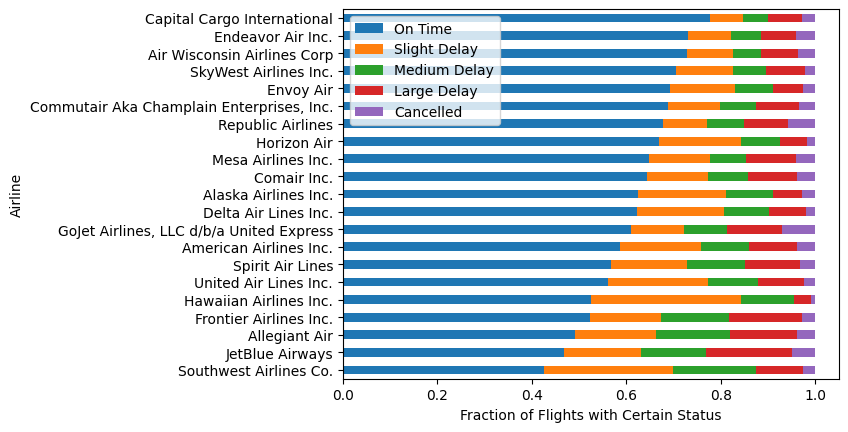

<Figure size 500x300 with 0 Axes>

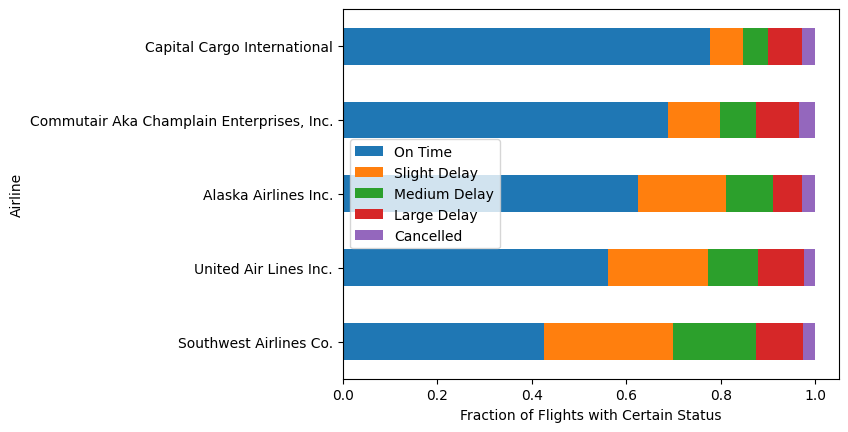

In [14]:
from matplotlib.transforms import Bbox

count_matrix = df.groupby(['Airline', 'FlightStatus']).size().unstack()
count_matrix.columns = pd.CategoricalIndex(count_matrix.columns.values, ordered=True, categories=['OnTime', 'SlightDelay', 'MediumDelay', 'LargeDelay', 'Cancelled'])
count_matrix = count_matrix.sort_index(axis=1)
count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)
count_matrix_norm.sort_values('OnTime', inplace=True)

plt.figure(figsize=(5,3))
count_matrix_norm.plot(kind='barh', stacked=True)
plt.xlabel('Fraction of Flights with Certain Status')
plt.legend(["On Time", "Slight Delay", "Medium Delay", "Large Delay", "Cancelled"], loc=0)
plt.savefig('../figures/flight_status_per_airline.png', bbox_inches='tight', dpi=300)
plt.show()

plt.figure(figsize=(5,3))
count_matrix_norm[::5].plot(kind='barh', stacked=True)
plt.xlabel('Fraction of Flights with Certain Status')
plt.legend(["On Time", "Slight Delay", "Medium Delay", "Large Delay", "Cancelled"], loc=0)
plt.savefig('../figures/flight_status_per_airline_legible', dpi=300, bbox_inches='tight')
plt.show()



It seems that passenger airlines are much more likely to be delayed than cargo airlines. We see many familiar Airlines near the bottom of the On Time percentage, while lesser known shipping Airlines like "Capital Cargo Internation" have stellar On Time percentages.

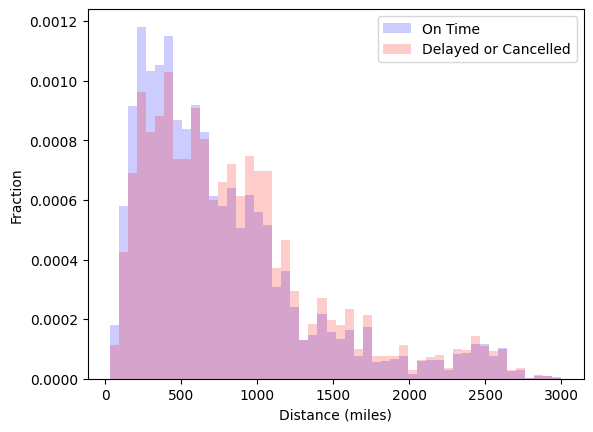

In [7]:
bin_range = (df['Distance'].min(), 3000)

bins = 50

plt.hist(df[df['OnTime']==True]['Distance'],alpha=0.2,label="On Time",range=bin_range,bins=bins,density=True, color="blue")
plt.hist(df[df['OnTime']==False]['Distance'],alpha=0.2,label="Delayed or Cancelled",range=bin_range,bins=bins,density=True,color="red")
plt.legend()
plt.ylabel('Fraction')
plt.xlabel('Distance (miles)')
plt.savefig('../figures/distance_vs_ontime_or_delayed.png', dpi=300)
plt.show()

It seems that flights are slightly more likely to be on time when flying short distances than longer distances. Overall this is a less significant effect than I had initially expected.

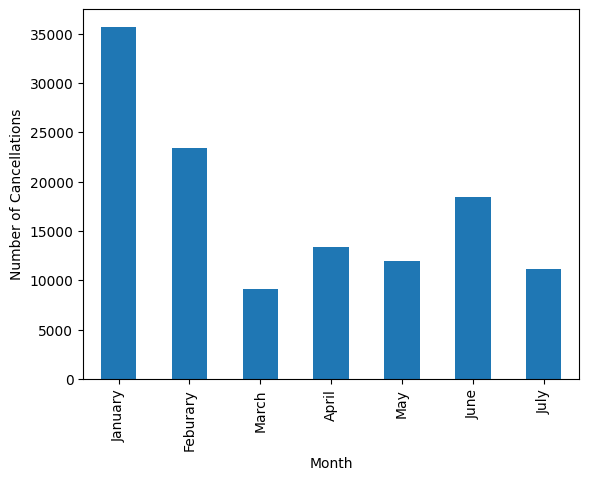

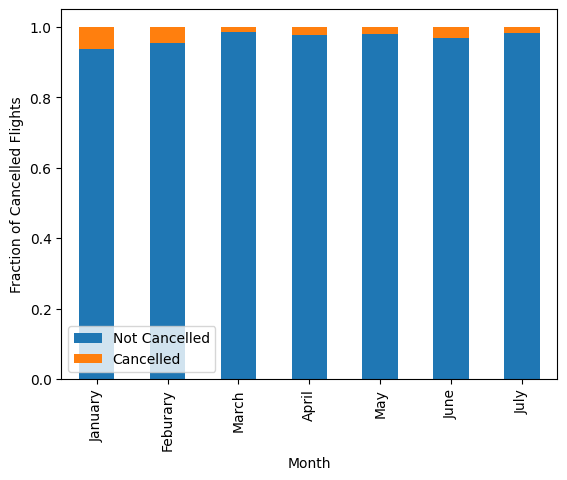

In [35]:
count_df = pd.DataFrame(df[df["Cancelled"]==True].groupby(['Month']).size())
fig, ax = plt.subplots()
count_df.plot(kind="bar", legend=False, ax=ax)
ax.set_xticklabels(["January", "Feburary", "March", "April", "May", "June", "July"])
ax.set_ylabel("Number of Cancellations")
plt.savefig('../figures/num_cancellations_per_month.png', dpi=300, bbox_inches='tight')

count_matrix = df.groupby(['Month', 'Cancelled']).size().unstack()
count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)

fig, ax = plt.subplots()
count_matrix_norm.plot(kind='bar', stacked=True, ax=ax)
plt.ylabel('Fraction of Cancelled Flights')
plt.legend(["Not Cancelled", "Cancelled"], loc=0)
ax.set_xticklabels(["January", "Feburary", "March", "April", "May", "June", "July"])
plt.savefig('../figures/cancellations_percentage_per_month.png', dpi=300, bbox_inches='tight')
plt.show()

I remembered that over the Summer there seemed to a lot of flight cancellations. I wanted to check this against the actual data, and was shocked that flight cancellations did not reach the peak of January and Feburary of this year.

<Figure size 500x1000 with 0 Axes>

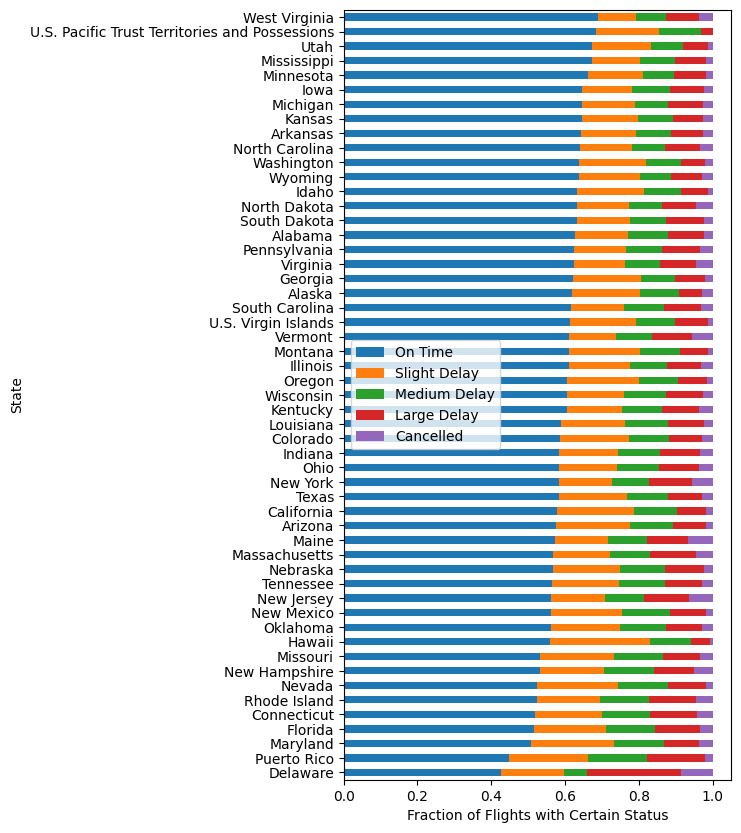

In [16]:
count_matrix = df.groupby(['DestStateName', 'FlightStatus']).size().unstack()
count_matrix.columns = pd.CategoricalIndex(count_matrix.columns.values, ordered=True, categories=['OnTime', 'SlightDelay', 'MediumDelay', 'LargeDelay', 'Cancelled'])
count_matrix = count_matrix.sort_index(axis=1)
count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)
count_matrix_norm.sort_values('OnTime', inplace=True)

plt.rcParams['figure.figsize'] = (5, 10)
plt.figure(figsize=(5,10))
count_matrix_norm.plot(kind='barh', stacked=True)
plt.xlabel('Fraction of Flights with Certain Status')
plt.ylabel('State')
plt.legend(["On Time", "Slight Delay", "Medium Delay", "Large Delay", "Cancelled"], loc=0)
plt.savefig('../figures/distance_vs_ontime_or_delayed.png', dpi=300, bbox_inches='tight')
plt.show()

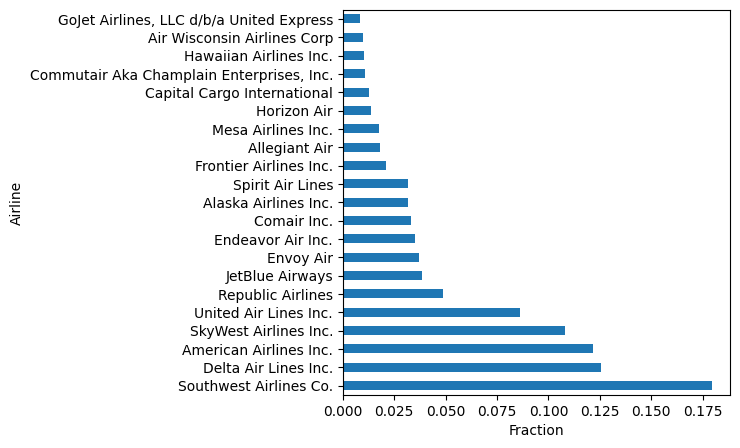

In [20]:
plt.figure(figsize=(5,5))
pd.value_counts(df['Airline'], normalize=True).plot.barh()
plt.ylabel('Airline')
plt.xlabel('Fraction')
plt.savefig('../figures/airline_eda.png', dpi=300, bbox_inches='tight')
plt.show()

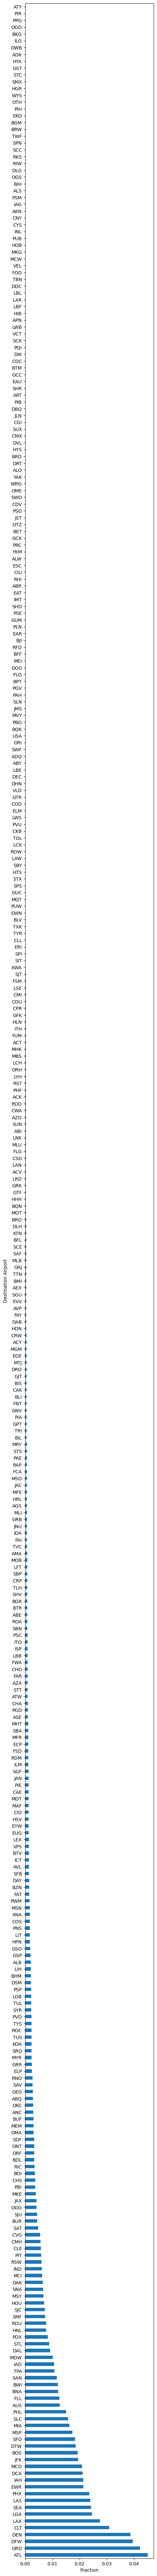

In [26]:
plt.figure(figsize=(5,100))
pd.value_counts(df['Dest'], normalize=True).plot.barh()
plt.ylabel('Destination Airport')
plt.xlabel('Fraction')
plt.savefig('../figures/dest_eda.png', dpi=300, bbox_inches='tight')
plt.show()

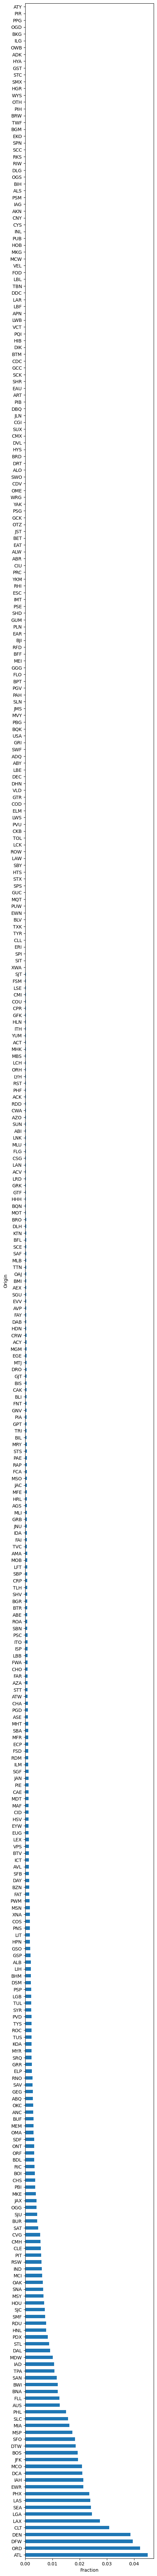

In [27]:
plt.figure(figsize=(5,100))
pd.value_counts(df['Origin'], normalize=True).plot.barh()
plt.ylabel('Origin')
plt.xlabel('Fraction')
plt.savefig('../figures/origin_eda.png', dpi=300, bbox_inches='tight')
plt.show()

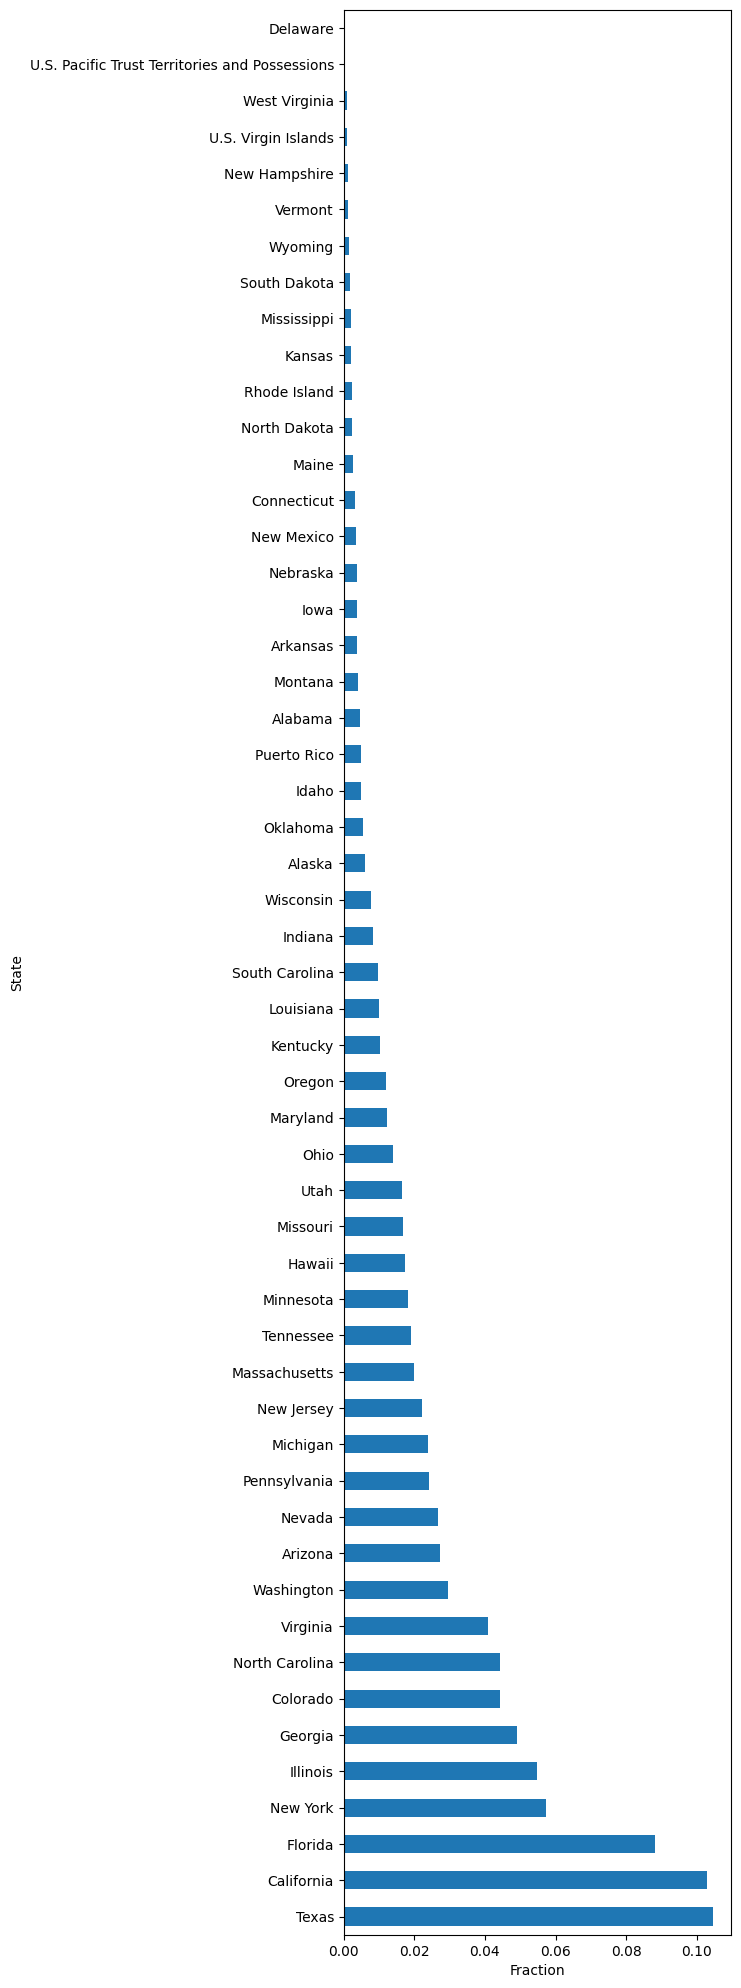

In [30]:
plt.figure(figsize=(5,25))
pd.value_counts(df['DestStateName'], normalize=True).plot.barh()
plt.ylabel('State')
plt.xlabel('Fraction')
plt.savefig('../figures/dest_state_eda.png', dpi=300, bbox_inches='tight')
plt.show()

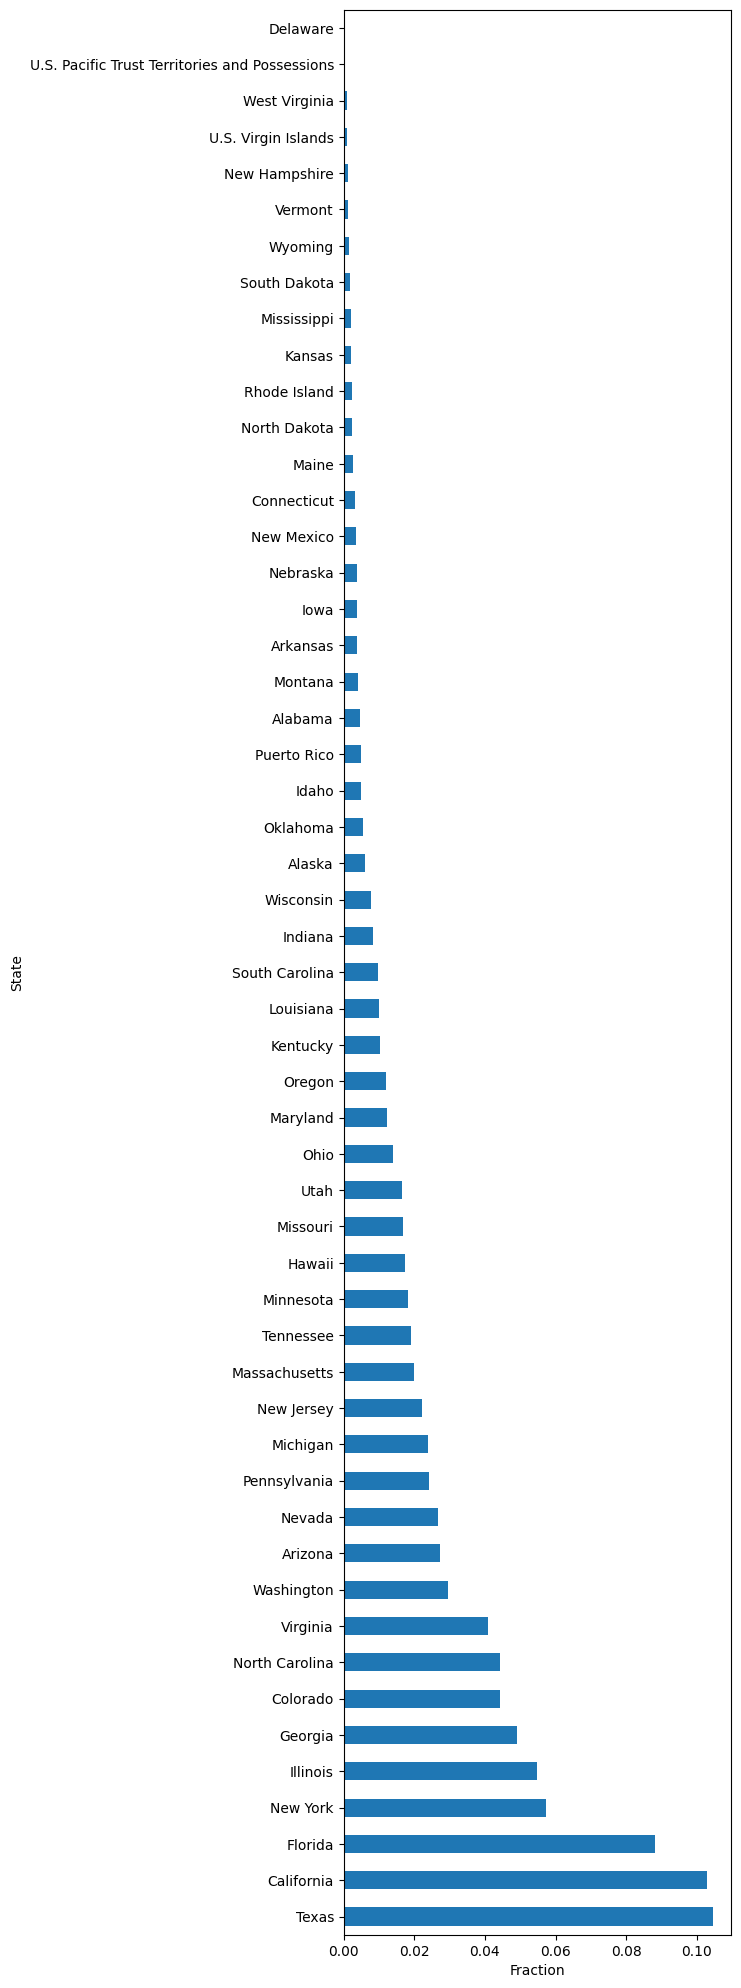

In [29]:
plt.figure(figsize=(5,25))
pd.value_counts(df['OriginStateName'], normalize=True).plot.barh()
plt.ylabel('State')
plt.xlabel('Fraction')
plt.savefig('../figures/origin_state_eda.png', dpi=300, bbox_inches='tight')
plt.show()

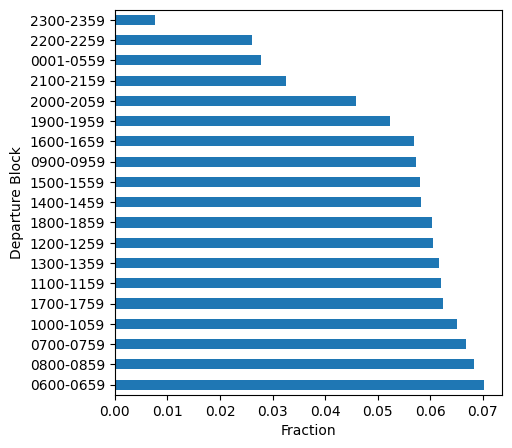

In [31]:
plt.figure(figsize=(5,5))
pd.value_counts(df['DepTimeBlk'], normalize=True).plot.barh()
plt.ylabel('Departure Block')
plt.xlabel('Fraction')
plt.savefig('../figures/departure_block_eda.png', dpi=300, bbox_inches='tight')
plt.show()

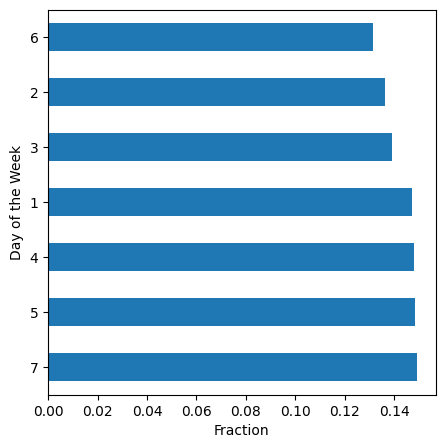

In [33]:
plt.figure(figsize=(5,5))
pd.value_counts(df['DayOfWeek'], normalize=True).plot.barh()
plt.ylabel('Day of the Week')
plt.xlabel('Fraction')
plt.savefig('../figures/weekday_eda.png', dpi=300, bbox_inches='tight')
plt.show()

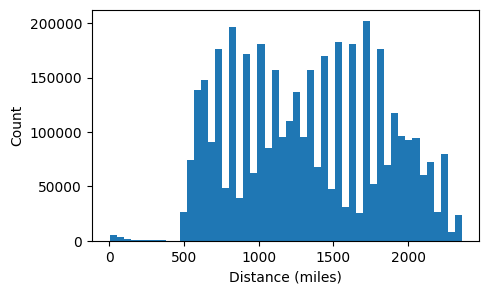

In [32]:
plt.figure(figsize=(5,3))

df['CRSDepTime'].plot.hist(bins = 50)
plt.xlabel('Distance (miles)')
plt.ylabel('Count')
plt.savefig('../figures/CRS_eda.png', dpi=300, bbox_inches='tight')
plt.show()

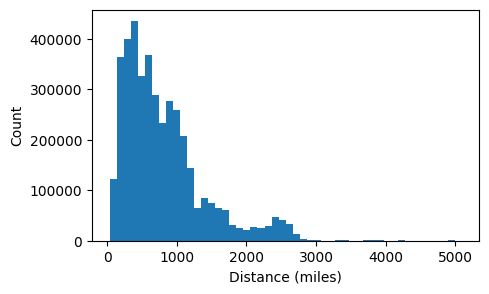

In [21]:
plt.figure(figsize=(5,3))

df['Distance'].plot.hist(bins = 50)
plt.xlabel('Distance (miles)')
plt.ylabel('Count')
plt.savefig('../figures/distance_eda.png', dpi=300, bbox_inches='tight')
plt.show()

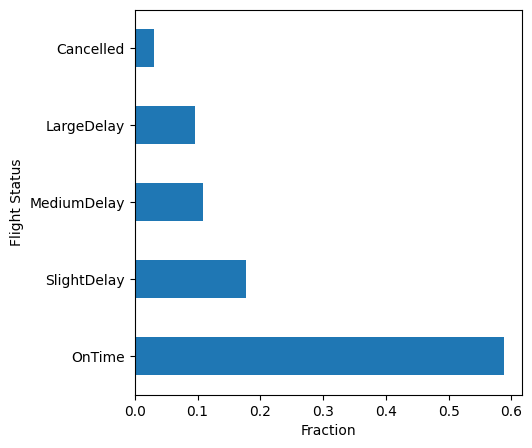

In [34]:
plt.figure(figsize=(5,5))
pd.value_counts(df['FlightStatus'], normalize=True).plot.barh()
plt.ylabel('Flight Status')
plt.xlabel('Fraction')
plt.savefig('../figures/flight_status.png', dpi=300, bbox_inches='tight')
plt.show()

# Splitting and Preprocessing 

In [8]:
# Check for missing values
perc_missing_per_ftr = df.isnull().sum(axis=0)/df.shape[0]
print('fraction of missing values in features:')
print(perc_missing_per_ftr[perc_missing_per_ftr > 0])

# Replace NaN features with 0
df['DepDelayMinutes'] = df['DepDelayMinutes'].fillna(0)

fraction of missing values in features:
DepDelayMinutes    0.029545
dtype: float64


In [37]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold

X = df.drop(['Cancelled','OnTime','SlightDelay','MediumDelay','LargeDelay', 'DepDelayMinutes', 'FlightStatus'], axis=1)
y = df['FlightStatus']

random_state = 42

# stratified train-test split
X_other, X_test, y_other, y_test = train_test_split(X,y,test_size = 0.025,stratify=y,random_state=random_state)
print('test balance:',np.unique(y_test,return_counts=True))

# do StratifiedKFold split on other
kf = StratifiedKFold(n_splits=4,shuffle=True,random_state=random_state)
for train_index, val_index in kf.split(X_other,y_other):
    print('new fold')
    X_train = X_other.iloc[train_index]
    y_train = y_other.iloc[train_index]
    X_val = X_other.iloc[val_index]
    y_val = y_other.iloc[val_index]
    
    onehot_ftrs = ["Airline", "Dest", "DestStateName", "Origin", "OriginStateName", "DayOfWeek", "DepTimeBlk", "Month"]
    std_ftrs = ['Distance','CRSDepTime']

    preprocessor = ColumnTransformer(
        transformers=[
            ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'), onehot_ftrs),
            ('std', StandardScaler(), std_ftrs)])

    clf = Pipeline(steps=[('preprocessor', preprocessor)])

    X_train_prep = clf.fit_transform(X_train)
    X_val_prep = clf.transform(X_val)
    X_test_prep = clf.transform(X_test)

    print(X_train_prep.shape)
    print(X_val_prep.shape)
    print(X_test_prep.shape)

test balance: (array(['Cancelled', 'LargeDelay', 'MediumDelay', 'OnTime', 'SlightDelay'],
      dtype=object), array([ 3080,  9732, 11141, 59952, 18053]))
new fold
(array(['Cancelled', 'LargeDelay', 'MediumDelay', 'OnTime', 'SlightDelay'],
      dtype=object), array([  90084,  284667,  325859, 1753609,  528051]))
(array(['Cancelled', 'LargeDelay', 'MediumDelay', 'OnTime', 'SlightDelay'],
      dtype=object), array([ 30028,  94888, 108619, 584537, 176018]))
(2982270, 912)
(994090, 912)
(101958, 912)
new fold
(array(['Cancelled', 'LargeDelay', 'MediumDelay', 'OnTime', 'SlightDelay'],
      dtype=object), array([  90084,  284666,  325858, 1753610,  528052]))
(array(['Cancelled', 'LargeDelay', 'MediumDelay', 'OnTime', 'SlightDelay'],
      dtype=object), array([ 30028,  94889, 108620, 584536, 176017]))



KeyboardInterrupt

